# Adaptive Filter
This notebooks uses the "padasip" module to create Apadative Filters for time series prediction.

In [1]:
import csv, os

import matplotlib.pyplot as plt
import numpy as np
import padasip as pa
import pandas as pd

Functions for importing stock dividend data

In [2]:
# Split Dataframe into train and test set
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

def get_stock_data():
    # Collect list of all companies we have data for

    # Get list of file names
    fileList = os.listdir("../data/series/good")

    # Loop through file names and collect ticker symbols
    companyList = []
    for file in fileList:
        companyName = file.split("_")[0]
        if companyName not in [".DS",".ipynb"]:
            companyList.append(companyName)

    # Add to ignore list if no data is available
    # Yahoo Finance will occasionally not through error
    # for some companies during GetMetrics, which end up creating blank
    # csvs that we can simply ignore here
    ignoreList = ["FFMR","FMCB"]
    stockList = list(set(companyList).difference(ignoreList))

    # Load and store data in initial Dataframe
    df_ = {}
    for i in stockList:
        df_[i] = pd.read_csv("../data/series/good/" + i + "_dividends_fixed.csv", index_col="Date", parse_dates=["Date"])

    # Create new Dataframe that contains data for each company
    # split at specified year
    df_new = {}
    for i in stockList:
        df_new[i] = {}
        df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2006", "0")
    
    return df_new

Overwritting the AdaptiveFilter class to include an optimization function avialable on a different branch of padasip.

In [3]:
class AdaptiveFilter(pa.filters.base_filter.AdaptiveFilter):
    def explore_learning(self, d, x, mu_start=0, mu_end=1., steps=100, ntrain=0.5, epochs=1, criteria="MSE", target_w=False):
        mu_range = np.linspace(mu_start, mu_end, steps)
        errors = np.zeros(len(mu_range))
        for i, mu in enumerate(mu_range):
            # init
            self.init_weights("zeros")
            self.mu = mu
            # run
            y, e, w = self.pretrained_run(d, x, ntrain=ntrain, epochs=epochs)
            if type(target_w) != bool:
                errors[i] = self.get_mean_error(w[-1]-target_w, function=criteria)
            else:
                errors[i] = self.get_mean_error(e, function=criteria)
        return errors, mu_range    
    

    def get_valid_error(self, x1, x2=-1):
        if type(x2) == int and x2 == -1:
            try:    
                e = np.array(x1)
            except:
                raise ValueError('Impossible to convert series to a numpy array')        
        # two series
        else:
            try:
                x1 = np.array(x1)
                x2 = np.array(x2)
            except:
                raise ValueError('Impossible to convert one of series to a numpy array')
            if not len(x1) == len(x2):
                raise ValueError('The length of both series must agree.')
            e = x1 - x2
        return e

    def logSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return 10*np.log10(e**2)


    def MAE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.sum(np.abs(e)) / float(len(e))

    def MSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.dot(e, e) / float(len(e))

    def RMSE(self, x1, x2=-1):
        e = self.get_valid_error(x1, x2)
        return np.sqrt(np.dot(e, e) / float(len(e)))

    def get_mean_error(self, x1, x2=-1, function="MSE"):
        if function == "MSE":
            return self.MSE(x1, x2)
        elif function == "MAE":
            return self.MAE(x1, x2)
        elif function == "RMSE":
            return self.RMSE(x1, x2)
        else:
            raise ValueError('The provided error function is not known')

## Create Filter
The following cells define functions for creating and using an Adaptive Filter. **"fit_filter"** is the main function which takes in the desire, ticker, algorithm, and number of lags the Filter should be fitted to. This function then calls the **"create_filter"** function which runs an optimization algorithm to find the best mu for the given inputs. The optimal mu is then used to define and fit a filter. **"predict_filter"** can then be called to use the fit filter to run inference on new samples. **SE** is simply there to provide the squared error of the predictions since the padasip predict function does not return error.

In [4]:
def create_filter(data, n, filter_type='NLMS'):
    if n == 1:
        x = np.reshape(data,(data.shape[0],1))
    else:
        x = np.squeeze(pa.input_from_history(data, n)) # Input matrix
    N = len(x)
    d = np.zeros(N) # Intialize target with empty values
    for i, k in enumerate(range((n-1), N)):
        # Fill target with our desired values
        if n == 1:
            d[i] = data[k]
        else:
            d[i] = data[k+1]
    f = AdaptiveFilter(n=n, mu=0)
    errors_e, mu_range = f.explore_learning(d, x,
                mu_start=0.01,
                mu_end=1.,
                steps=100, ntrain=0.5, epochs=1,
                criteria="MSE")

    best_mu = mu_range[errors_e.argmin()]
    
    f = pa.filters.AdaptiveFilter(model=filter_type, n=n, mu=best_mu, w="random")
    y, e, w = f.run(d, x)
    return  y, e, w, f

def predict_filter(data, n, plot, f):
    x = np.squeeze(pa.input_from_history(data, n)) # Input matrix
    y = []
    for step in x:
        y.append(f.predict(step))
    
    if n == 1:
        return np.asarray(y).transpose()[0]
    return np.asarray(y)

def fit_filter(data, n, ticker, filter_type):
    y_train, e_train, w_train, f = create_filter(data[ticker]['Train'].values, n, filter_type)
    y_test  = predict_filter(data[ticker]['Test'].values, n, False, f)
    y = np.append(y_train, y_test)
    d = data[ticker]['Train'].append(data[ticker]['Test'])
    train = pd.Series(data=y_train , index=data[ticker]['Train'].index[n-1:])
    test = pd.Series(data=y_test , index=data[ticker]['Test'].index[n-1:])
    test_error = SE(y_test, data[ticker]['Test'])
    mse = plot_filter_result(train, test, d, test_error, n, ticker)
    
    return y_test, mse, f

def SE(y, d):
    error = []
    for pred, act in zip(y,d):
        error.append((pred - act)**2)
    return error

The next function simply defines the format of the prediction and error plots

In [5]:
def plot_filter_result(pred_train, pred_test, actual, error, n, tkr):   
    plt.figure(figsize=(5, 7.5))
    plt.subplot(211)
    plt.xlabel('No of iteration [-]')
    a = actual.plot(title=tkr, ylabel='Dividends')
    tr = pred_train.plot()
    ts = pred_test.plot()
    plt.legend(['Actual', 'Train Predictions', 'Test Predictions'], loc='upper left')
    mse = (1/(len(error) - n))* np.sum((error[: (len(error) - n)]))
    plt.subplot(212)
    plt.title(f'Filter MSE {mse:.5f}')
    plt.plot(error[: (len(error) - n)], 'r', label='Error')
    plt.axhline(y=mse, color='black', lw=1, linestyle='--')
    plt.tight_layout()
    plt.show()
    return mse

## Fit Filter
Below all the tickers and their dividend yields are imported and some parameters are defines. The following example will fit a Normalized Least-mean-squares (NLMS) filter using 5 steps of data for every prediction to the ABT stock.

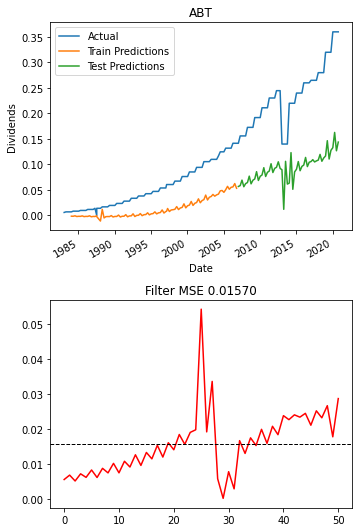

In [6]:
data = get_stock_data()
n = 5
ticker = 'ABT'
filter_type = 'NLMS'
preds, mse, f = fit_filter(data, n, ticker, filter_type)

## Comparison
Now filters for a group of stocks will fitted with a lag of 1, so that this method can be compared with the others in the project. View the **ModelComparison** notebook to see these comparisons

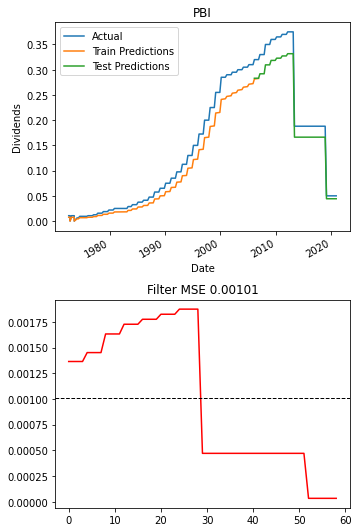

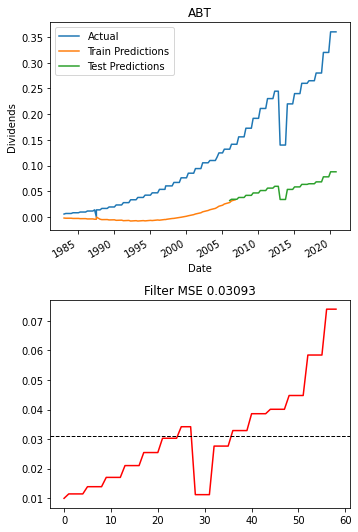

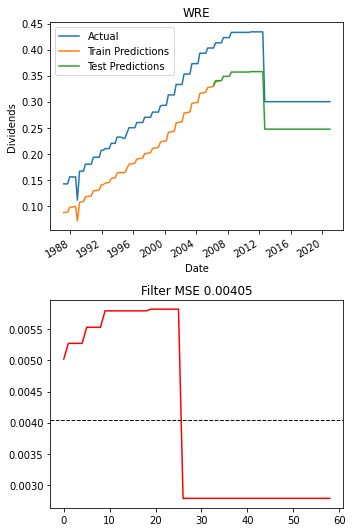

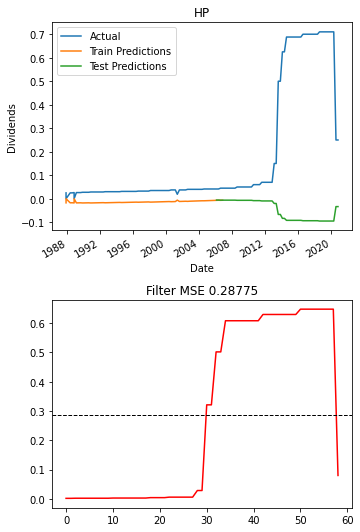

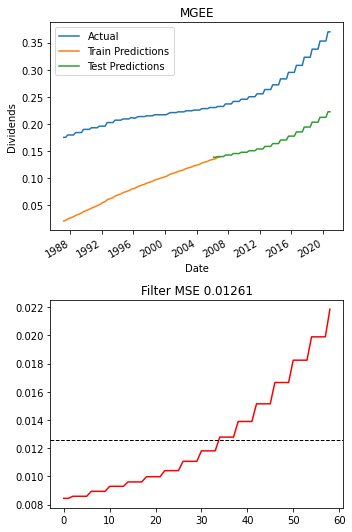

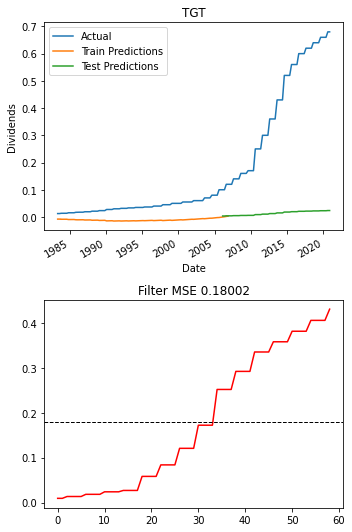

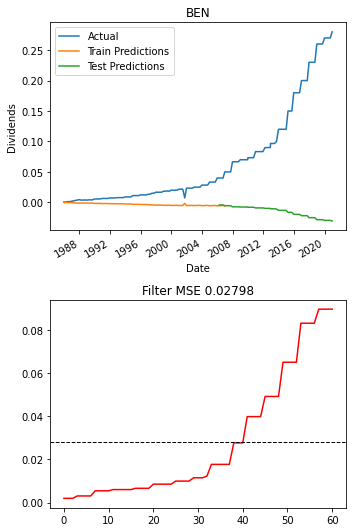

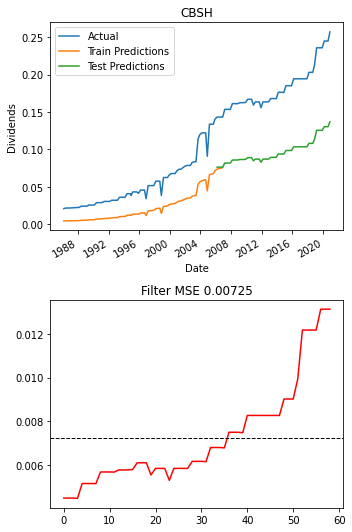

In [17]:
n = 1
lost_figs = ['PBI', 'ABT', 'WRE', 'HP']
kept_figs = ['MGEE', 'TGT', 'BEN', 'CBSH']

for t in lost_figs:
    preds_lost, mse_lost, _ = fit_filter(data, n, t, filter_type)
    np.save(f"../data/numpy/{t}_pred_af", preds_lost)

for t in kept_figs:
    preds_kept, mse_kept, _ = fit_filter(data, n, t, filter_type)
    np.save(f"../data/numpy/{t}_pred_af", preds_kept)

# Further Experimentation

## Adaptive System
The section below follows the example provided by the padasip documentation and implements a system to fit a filter and update it as new information is provided. Using the *”adapt”* function, the filter can update itself to include a new sample.

In [8]:
def apdaptive_system(f, test, n):
    x_test = np.squeeze(pa.input_from_history(test, n))
    d_test = np.zeros(len(x_test))
    N_test = len(x_test)
    for i, k in enumerate(range((n-1), N_test)):
        d_test[i] = test[k+1]

    actual = np.zeros(N_test)
    predict = np.zeros(N_test)

    # Simulate real-time prediction and update the filter
    for k in range(N_test):
        x_input = x_test[k]
        y = f.predict(x_input)
        d_actual = d_test[k]
        f.adapt(d_actual, x_input)
        actual[k] = d_actual
        predict[k] = y

    ## show results
    mse = (1/len(predict)) * np.sum((actual -predict)**2)
    plt.figure(figsize=(15,9))
    plt.subplot(211)
    plt.title("Adaptive Filter on test data (simulated)")
    plt.xlabel("Samples [k]")
    plt.plot(actual[n: (len(actual)-n)], "b", label="actual")
    plt.plot(predict[n: (len(predict)-n)], "g", label="predict")
    plt.legend()
    plt.subplot(212)
    plt.title(f'Filter MSE {mse:.4f}')
    plt.xlabel("Samples [k]")
    plt.plot(((actual[n: (len(actual)-n)] - predict[n: (len(predict)-n)])**2), "r", label="Error")
    plt.legend()
    plt.tight_layout()
    plt.show()

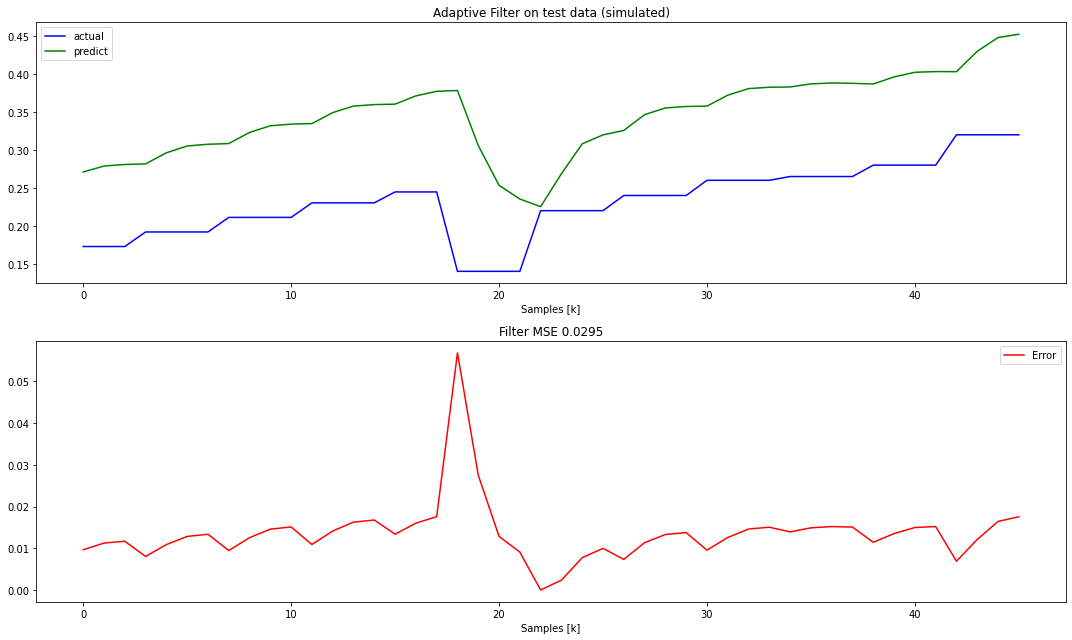

In [9]:
n = 5
ticker = 'ABT'
filter_type = 'NLMS'
test_data = data[ticker]['Test'].values
train_data = data[ticker]['Train'].values
_, _, _, f = create_filter(train_data, n)
apdaptive_system(f, test_data, n)

## Future Prediction
This final section implements a simple solution for predicting values further into the future. The filters from all preceding sections could only predict one step into the future. The system below predicts further into the future by feeding its own predictions into itself. When the filter runs out of actual test data to create predictions from, it will append its prediction to the end of the input window and pop the oldest value off. This results in a new input window with the final 4 real values and the first predicted value acting as the newest sample. Theoretically this process can be extend as far as the user desires, however the performance will degreed greatly the further in the future the filter is predicting.

In [10]:
def predict_future(test, preds, f, n=5):
    x_future = np.squeeze(pa.input_from_history(test, n))
    N_future = len(x_future) + preds
    d_future = np.zeros(N_future)
    
    for i, k in enumerate(range((n-1), len(x_future))):
        d_future[i] = test[k+1]

    actual = np.zeros(len(x_future))
    predict = np.zeros(N_future)
    
    future = x_future[-1]
    for k in range(N_future):
        if k >= len(x_future):    
            future = np.delete(future, 0)
            future = np.append(future, predict[k-1])
            y = f.predict(future)
            predict[k] = y
        else:
            x_input = x_future[k]
            y = f.predict(x_input)
            predict[k] = y
            d_actual = d_future[k]
            f.adapt(d_actual, x_input)
            actual[k] = d_actual
            predict[k] = y
    return predict

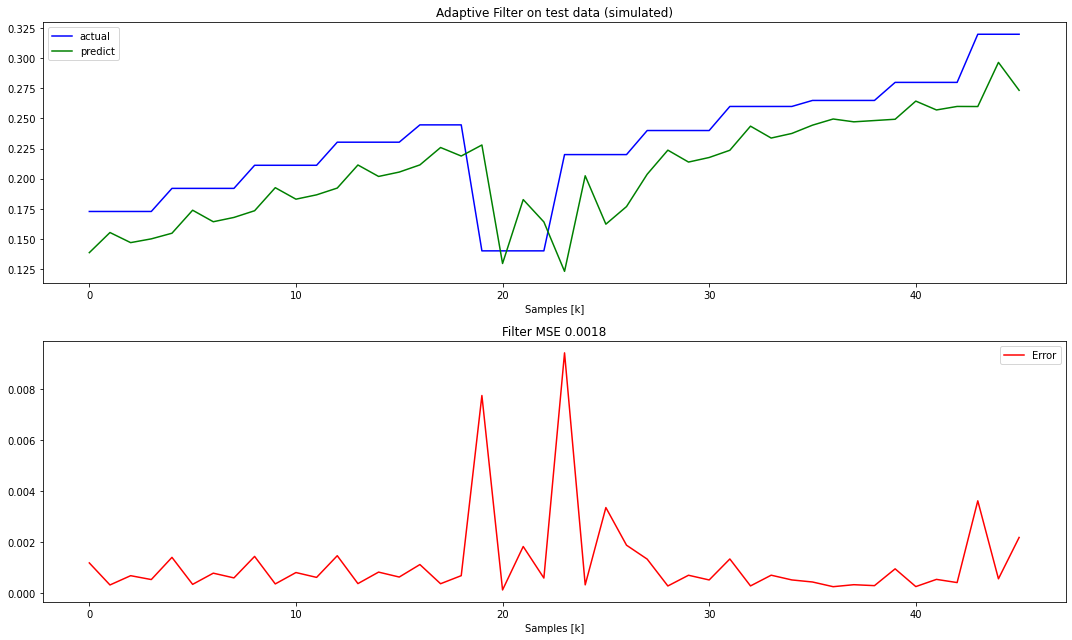

0.2810 predicted 1 step(s) into the future
0.2485 predicted 2 step(s) into the future
0.2819 predicted 3 step(s) into the future
0.2359 predicted 4 step(s) into the future
0.2738 predicted 5 step(s) into the future


In [11]:
n = 5
future_steps = 5
ticker = 'ABT'
filter_type = 'NLMS'
test_data = data[ticker]['Test'].values
train_data = data[ticker]['Train'].values
_, _, _, f = create_filter(train_data, n)
predict = predict_future(test_data[:-future_steps], future_steps, f)
actual = test_data[4:]

## show results
plt.figure(figsize=(15,9))
plt.subplot(211)
plt.title("Adaptive Filter on test data (simulated)")
plt.xlabel("Samples [k]")
plt.plot(actual[n: (len(actual)-n)], "b", label="actual")
plt.plot(predict[n: (len(predict)-n)], "g", label="predict")
plt.legend()

plt.subplot(212)
mse = (1/len(predict)) * np.sum((actual - predict)**2)
plt.title(f'Filter MSE {mse:.4f}')
plt.xlabel("Samples [k]")
plt.plot(((actual[n: (len(actual)-n)] - predict[n: (len(predict)-n)])**2), "r", label="Error")
plt.legend()
plt.tight_layout()

    
plt.show()

for time, pred in enumerate(predict[-5:]):
    print(f"{pred:.4f} predicted {time+1} step(s) into the future")